# Mutational Combos

In [26]:
import sys 
lab_path="/Users/andyzeng/Drive/Laptop/Dick_Lab/"
sys.path.append(lab_path+"AMLhierarchies/")
%load_ext rpy2.ipython

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
import copy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import scipy
import seaborn as sns
sc.set_figure_params(scanpy=True, dpi_save=200)
import Hierarchy_Tools as tk
import jenkspy

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [27]:
%%R -w 8 -h 4 --units in -r 200
library(tidyverse)
library(ggpubr)
library(ggsci)
library(ggExtra)
library(ggridges)
library(cowplot) 

In [28]:
hcat = sc.read_h5ad('Data/Hierarchy_Reference_3Cohorts.h5ad')
genomics = pd.read_csv("Data/Cohort_Combined_Cytogenetics_Mutations_Feb16.csv").set_index('Patient')

In [29]:
hcat

AnnData object with n_obs × n_vars = 864 × 7
    obs: 'Cohort', 'Cluster', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'NMF1', 'NMF2', 'NMF3'
    var: 'NMF1', 'NMF2', 'NMF3'
    uns: 'Cluster_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [30]:
LSCscores = pd.read_csv("../LSCscores_proper_TCGA_BEAT_LEUC.csv").set_index("Patient")
LSCscores['LSC-17'] = np.where(LSCscores['LSC17_RPKM'].isna(), LSCscores['LSC16_RPKM'], LSCscores['LSC17_RPKM'])
LSCscores['LinClass-7'] =  LSCscores['PrimScore_logTPM']
LSCscores

,LSC17_RPKM,LSC17_logTPM,LSC17_TPM,LSC16_RPKM,LSC16_logTPM,LSC16_TPM,PrimScore_RPKM,PrimScore_logTPM,PrimScore_TPM,Cohort,LSC-17,LinClass-7
Patient,,,,,,,,,,,,
TCGA-AB-2803,-7.262490,-0.313125,-10.093047,-3.535942,-0.135794,-4.914076,5.793291,0.873860,8.051228,TCGA,-7.262490,0.873860
TCGA-AB-2805,-2.211890,0.212774,-2.585635,-1.546420,0.329086,-1.807720,17.817380,1.104927,20.827999,TCGA,-2.211890,1.104927
TCGA-AB-2806,-36.746779,-0.202658,-44.267930,-33.378189,-0.033241,-40.209874,62.094142,1.454362,74.803268,TCGA,-36.746779,1.454362
TCGA-AB-2807,6.080639,0.614674,7.626483,8.767378,0.778068,10.996256,29.726580,1.433183,37.283792,TCGA,6.080639,1.433183
TCGA-AB-2808,-6.733081,0.055309,-8.739997,-3.661244,0.224157,-4.752543,27.818249,1.334065,36.109979,TCGA,-6.733081,1.334065
...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1636925_14H020,NaN,NaN,NaN,-14.082474,0.129089,-14.082473,25.060677,1.324897,25.060677,Leucegene,-14.082474,1.324897
GSM1636926_14H023,NaN,NaN,NaN,13.712848,0.932865,13.712848,7.692299,1.004439,7.692299,Leucegene,13.712848,1.004439
GSM1636927_14H027,NaN,NaN,NaN,25.335474,0.720950,25.335474,21.118044,1.275066,21.118044,Leucegene,25.335474,1.275066


In [31]:
hcat.obs[['Cohort']].join(genomics[['Age', 'Cytogenetic risk', 'ELN2017', 'FAB']]).\
        join(hcat.to_df()[['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like']]).\
        join(hcat.obs[['Cluster', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'NMF1', 'NMF2', 'NMF3']]).\
        join(LSCscores[['LSC-17', 'LinClass-7']]).\
        join(genomics.drop(['Cohort', 'Age', 'FAB', 'Cytogenetic risk', 'ELN2017'], axis=1)).to_csv("Data/Cohort_Hierarchy_Genomic_Annotations.csv")

In [32]:
# # 1086 driver mutations identified across patients
# # 664 driver mutations with VAF information
# # 516 driver mutations with VAF >= 30%
hcat.obs = hcat.obs.join(genomics.drop('Cohort', axis=1))
genomic_vaf = genomics.iloc[:,genomics.columns.str.contains('VAF')]
genomic_vaf = genomic_vaf.apply(lambda x: np.where(x >= 0.25, 'Positive', np.where(x < 0.25, 'Negative', 'NA')))
genomic_vaf.columns = genomic_vaf.columns+'25'
hcat.obs = hcat.obs.iloc[:,~hcat.obs.columns.str.contains('VAF')].join(genomic_vaf)
hcat.obs

,Cohort,Cluster,PC1,PC2,PC3,PC4,PC5,PC6,NMF1,NMF2,...,SMC1A_VAF25,SMC3_VAF25,SPI1_VAF25,SRSF2_VAF25,STAG2_VAF25,TET2_VAF25,TP53_VAF25,U2AF1_VAF25,WT1_VAF25,ZRSR2_VAF25
TCGA-AB-2803,TCGA,GMP,0.315948,0.053389,-0.097422,0.100484,0.063278,-0.074975,0.419315,1.762287,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
TCGA-AB-2805,TCGA,Mature,-0.166651,-0.351056,-0.074085,-0.055883,0.067818,0.151966,0.556737,0.088418,...,Negative,Negative,NA,NA,Negative,Negative,Negative,Negative,Negative,NA
TCGA-AB-2806,TCGA,GMP,0.477078,0.107512,0.022680,-0.054709,0.140637,0.156436,0.288771,2.254078,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
TCGA-AB-2807,TCGA,Primitive,-0.254393,0.088499,0.033469,0.110217,0.021335,0.157675,1.136698,0.111412,...,Negative,Negative,NA,NA,Negative,Negative,Negative,Negative,Negative,NA
TCGA-AB-2808,TCGA,Intermediate,0.060838,-0.057681,0.229163,0.041475,0.118574,0.004007,0.514792,0.876387,...,Negative,Negative,NA,NA,Negative,Negative,Negative,Negative,Negative,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14H020,Leucegene,Intermediate,0.216257,0.176750,-0.015854,-0.034623,-0.087951,-0.007426,0.768299,1.595827,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
14H023,Leucegene,Primitive,-0.200947,0.086947,0.132712,-0.183926,0.040554,-0.037923,1.101574,0.239792,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
14H027,Leucegene,Primitive,-0.213478,0.109488,0.021103,0.076139,-0.178613,0.029909,1.201405,0.305316,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
14H031,Leucegene,Mature,-0.146454,-0.232116,0.247041,-0.001641,-0.028159,-0.087618,0.616141,0.189294,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# Checkpoint

## Combined

In [33]:
hcat.obs['FLT3_TKD_VAF25'] = np.where(hcat.obs['FLT3_TKD'] == "Positive", hcat.obs['FLT3_VAF25'], hcat.obs['FLT3_TKD'])
hcat.obs['FLT3-ITD_VAF25'] = np.where(hcat.obs['FLT3-ITD_VAF25'] == 'NA', hcat.obs['FLT3-ITD_mut'], hcat.obs['FLT3-ITD_VAF25'])
hcat.obs['DNMT3A_R882_VAF25'] = np.where(hcat.obs['DNMT3A_R882'] == "Positive", hcat.obs['DNMT3A_VAF25'], hcat.obs['DNMT3A_R882'])
hcat.obs['DNMT3A_Other_VAF25'] = np.where((hcat.obs['DNMT3A_mut'] == "Positive") & (hcat.obs['DNMT3A_R882'] == "Negative"), hcat.obs['DNMT3A_VAF25'], 
                                            np.where((hcat.obs['DNMT3A_mut'] == "Positive"), 'Negative', hcat.obs['DNMT3A_mut']))
hcat.obs['NPM1_VAF25'] = hcat.obs['NPM1_mut']

In [34]:
newcat_obs = hcat.obs[['PC1', 'PC2', 'FLT3_TKD_VAF25', 'NRAS_VAF25', 'NPM1_mut', 'FLT3-ITD_mut', 'Cytogenetic risk', 'FAB']]
newcat_obs = newcat_obs.fillna('NA')

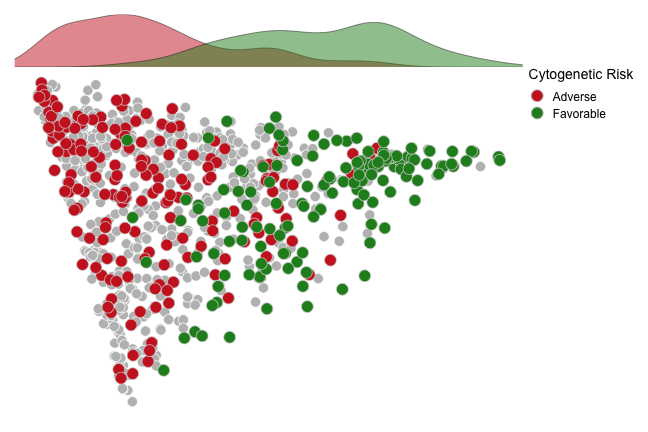

In [35]:
%%R -i newcat_obs -h 6 -w 9 --units in

p <- newcat_obs %>% 
    ggplot(aes(x = PC1, y = PC2)) + 
    geom_point(data = subset(newcat_obs, `Cytogenetic risk` %in% c('NA', 'Intermediate')), size=4.5, shape=21, fill ='grey', color='white') + 
    geom_point(data = subset(newcat_obs, `Cytogenetic risk` == 'Adverse'), aes(fill = `Cytogenetic risk`), size=5.2, shape=21, color='lightgrey') + 
    geom_point(data = subset(newcat_obs, `Cytogenetic risk` == 'Favorable'), aes(fill = `Cytogenetic risk`), size=5.2, shape=21, color='lightgrey') + 
    scale_fill_manual(values=c('firebrick3', 'forestgreen')) + 
    #scale_fill_aaas() + 
    theme_void() + 
    labs(fill = "Cytogenetic Risk") +
    theme(legend.title = element_text(size = 14), 
          legend.text = element_text(size = 12), 
          legend.justification = "top", 
          plot.margin = unit(c(1, 1, 1, 1), "lines"))
    
# Marginal densities along x axis
xdens <- axis_canvas(p, axis = "x") +
  geom_density(data = subset(newcat_obs, `Cytogenetic risk` %in% c("Adverse", "Favorable")), 
               aes(x = PC1, fill = `Cytogenetic risk`),
              alpha = 0.5, size = 0.2) +
    scale_fill_manual(values=c('firebrick3', 'forestgreen'))
            
p1 <- insert_xaxis_grob(p, xdens, grid::unit(.15, "null"), position = "top")
ggdraw(p1)

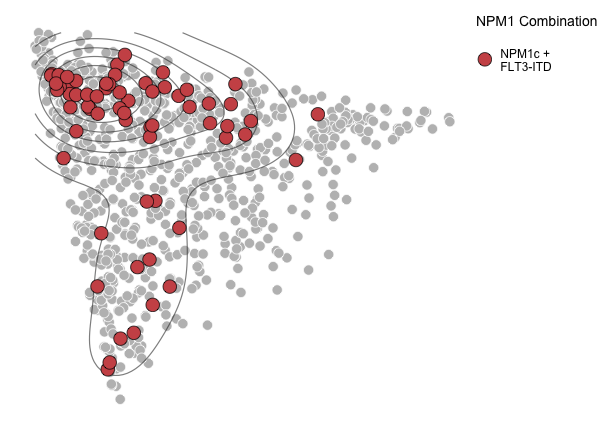

In [36]:
%%R -i newcat_obs -h 6 -w 8.5 --units in

newcat_obs <- newcat_obs %>% mutate(NPM1_combo = if_else(NPM1_mut == "Positive", 
                                                         if_else((`FLT3-ITD_mut` == 'Positive'), '\nNPM1c +\nFLT3-ITD\n', 'NA'), 'NA'))

newcat_obs %>% 
    ggplot(aes(x = PC1, y = PC2)) + 
    geom_point(data = subset(newcat_obs, `NPM1_combo` == 'NA'), size=4.5, shape=21, fill ='grey', color='white') + 
    stat_density_2d(data = subset(newcat_obs, `NPM1_combo` == '\nNPM1c +\nFLT3-ITD\n'), alpha=0.6, size=0.56, color='grey20', h=0.35) + 
    geom_point(data = subset(newcat_obs, `NPM1_combo` == '\nNPM1c +\nFLT3-ITD\n'), aes(fill = `NPM1_combo`), size=6, shape=21, color='black') + 
    scale_fill_manual(values = c('indianred3')) + 
    theme_void() + 
    labs(fill = "NPM1 Combination") +
    theme(legend.title = element_text(size = 14), 
          legend.text = element_text(size = 12), 
          legend.justification = "top", 
          plot.margin = unit(c(1, 1, 1, 1), "lines"))

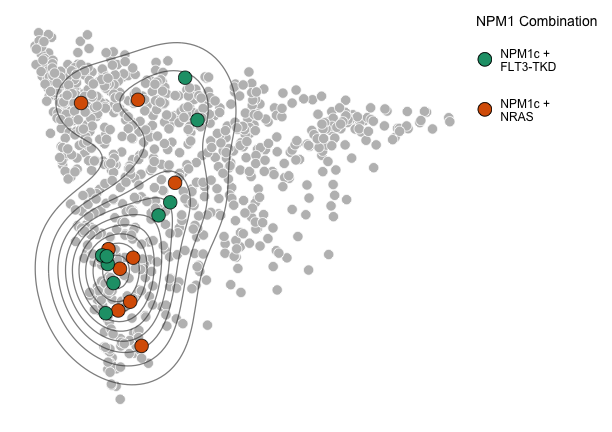

In [37]:
%%R -i newcat_obs -h 6 -w 8.5 --units in

newcat_obs <- newcat_obs %>% mutate(NPM1_combo = if_else(NPM1_mut == "Positive", 
                                                         if_else((`NRAS_VAF25` == 'Positive'), '\nNPM1c +\nNRAS\n',
                                                                 if_else((`FLT3_TKD_VAF25` == 'Positive'), '\nNPM1c +\nFLT3-TKD\n', 'NA')), 'NA'))

newcat_obs %>% 
    ggplot(aes(x = PC1, y = PC2)) + 
    geom_point(data = subset(newcat_obs, `NPM1_combo` == 'NA'), size=4.5, shape=21, fill ='grey', color='white') + 
    geom_density_2d(data = subset(newcat_obs, `NPM1_combo` != 'NA'), size=0.6, alpha=0.6, color='grey20', h=0.35) + 
    geom_point(data = subset(newcat_obs, `NPM1_combo` == '\nNPM1c +\nNRAS\n'), aes(fill = `NPM1_combo`), size=6, shape=21, color='black') + 
    geom_point(data = subset(newcat_obs, `NPM1_combo` == '\nNPM1c +\nFLT3-TKD\n'), aes(fill = `NPM1_combo`), size=6, shape=21, color='black') + 
    scale_fill_brewer(palette='Dark2') + 
    theme_void() + 
    labs(fill = "NPM1 Combination") +
    theme(legend.title = element_text(size = 14), 
          legend.text = element_text(size = 12), 
          legend.justification = "top", 
          plot.margin = unit(c(1, 1, 1, 1), "lines"))

## With Marginal Plots

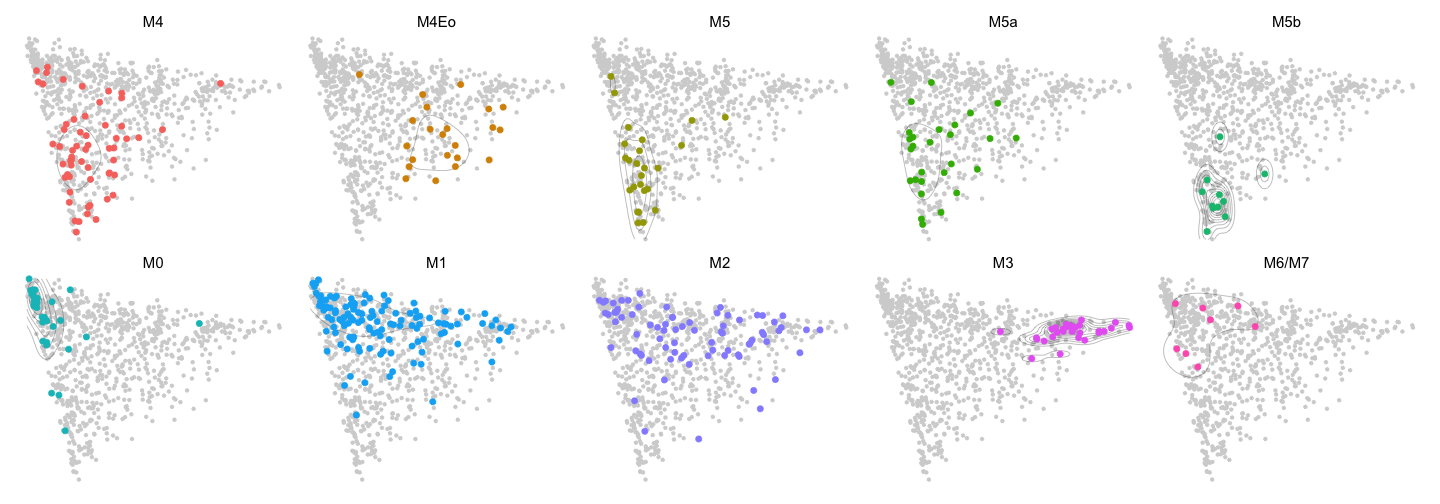

In [38]:
%%R -i newcat_obs -h 7 -w 20 --units in

background <- newcat_obs %>% select(-FAB)

p <- newcat_obs %>% 
    filter(FAB != 'NA') %>%
    #filter(!(FAB %in% c('M6', 'M7'))) %>%
    mutate(FAB = ifelse(FAB == 'M5B', 'M5b', 
                        ifelse(FAB == 'M5A', 'M5a', 
                               ifelse(FAB %in% c('M6', 'M7'), 'M6/M7', FAB)))) %>%
    mutate(FAB = factor(FAB, levels=c('M4', 'M4Eo', 'M5', 'M5a', 'M5b', 'M0', 'M1', 'M2', 'M3', 'M6/M7'))) %>%
    ggplot(aes(x = PC1, y = PC2)) + 
    geom_point(data=background, color='lightgrey', size=1.3, alpha=1) +
    geom_density_2d(alpha=0.4, size=0.3, color='black') + 
    geom_point(size=2.5, aes(color=FAB)) +
    facet_wrap(.~FAB, nrow=2) + 
    #scale_fill_brewer(palette='Dark2') + 
    theme_void() + 
    labs(fill = "Cytogenetic Risk") +
    theme(legend.justification = "top", 
          legend.position = "none", 
          plot.margin = unit(c(1, 1, 1, 1), "lines"),
          strip.text.x = element_text(size = 15))
    
ggdraw(p)


R[write to console]: Picking joint bandwidth of 0.051



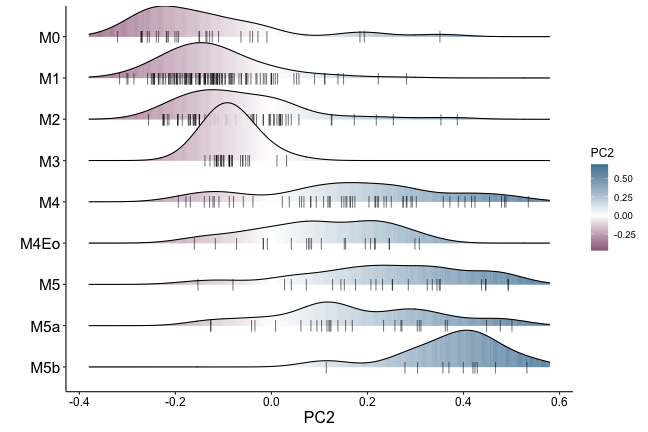

In [39]:
%%R -h 6 -w 9 --units in

newcat_obs %>% 
    filter(!is.na(FAB)) %>%
    filter(!(FAB %in% c('NA', 'M6', 'M7'))) %>% 
    mutate(FAB = ifelse(FAB=='M5A', 'M5a', ifelse(FAB=='M5B', 'M5b', FAB)),
           FAB = factor(FAB, levels=c('M5b', 'M5a', 'M5', 'M4Eo', 'M4', 'M3', 'M2', 'M1', 'M0'))) %>%
    ggplot(aes(y = FAB, x = -PC2, fill=stat(x))) +
    geom_density_ridges_gradient(
        jittered_points = TRUE, scale = 1.4,
        position = position_points_jitter(width = 0, height = 0), 
        point_shape = '|', point_size = 4, point_alpha = 0.6) +
    scale_fill_gradient2(low='#71305D', high='#5083A2', name = "PC2") +
    xlab('PC2') +
    theme_pubr() + 
    ylab('') +
    xlim(c(-0.38, 0.58)) + 
    theme(legend.position='right', 
          axis.text.y = element_text(size=15.5),
          axis.title.x = element_text(size=16))# + ggsave("Mutations/figures/Combo2_Hierarchy_PC2_unimodal.png", dpi='retina', height=9.5, width=10)

R[write to console]: Picking joint bandwidth of 0.0471



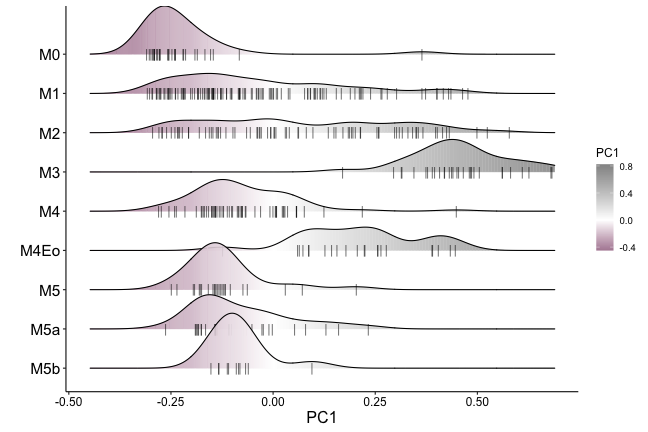

In [40]:
%%R -h 6 -w 9 --units in

newcat_obs %>% 
    filter(!is.na(FAB)) %>%
    filter(!(FAB %in% c('NA', 'M6', 'M7'))) %>% 
    mutate(FAB = ifelse(FAB=='M5A', 'M5a', ifelse(FAB=='M5B', 'M5b', FAB)),
           FAB = factor(FAB, levels=c('M5b', 'M5a', 'M5', 'M4Eo', 'M4', 'M3', 'M2', 'M1', 'M0'))) %>%
    ggplot(aes(y = FAB, x = PC1, fill=stat(x))) +
    geom_density_ridges_gradient(
        jittered_points = TRUE, scale = 1.4,
        position = position_points_jitter(width = 0, height = 0), 
        point_shape = '|', point_size = 4, point_alpha = 0.6) +
    scale_fill_gradient2(low='#71305D', high='#949494', name = "PC1") +
    theme_pubr() + 
    ylab('') +
    xlim(c(-0.45, 0.69)) + 
    theme(legend.position='right', 
          axis.text.y = element_text(size=15.5),
          axis.title.x = element_text(size=16))# + ggsave("Mutations/figures/Combo2_Hierarchy_PC2_unimodal.png", dpi='retina', height=9.5, width=10)

# Cytogenetic Alterations

Plot key cytogenetic alterations along PC1 and PC2

In [81]:
cytogenetics = hcat.obs[['PC1', 'PC2', 'Normal Karyotype', 'inv(3): GATA2/MECOM', 't(11q23): MLL_Fusion', 't(9;22): BCR-ABL', 
          't(5;11): NUP98-NSD1', 'inv(16): CBFB-MYH11', 't(8;21): RUNX1-RUNX1T1', 't(15;17): PML-RARA', 
          'Complex Karyotype', 'Monosomy 5', 'del(5q)', 'Monosomy 7', 'del(7q)', 'Monosomy 17', 'del(17p)']]
cytogenetics = cytogenetics.fillna('NA')

## PC1

R[write to console]: Picking joint bandwidth of 0.0621



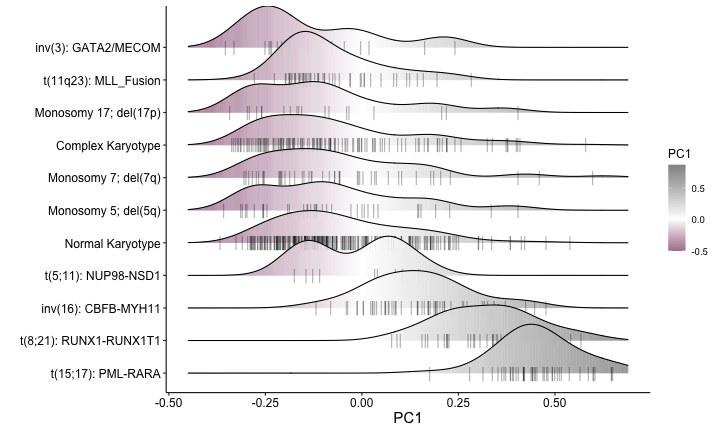

In [84]:
%%R -i cytogenetics -h 6 -w 10 --units in

alteration <- cytogenetics %>% 
    mutate(`Monosomy 5; del(5q)` = ifelse(`Monosomy 5` == "NA", `del(5q)`, `Monosomy 5`),
           `Monosomy 7; del(7q)` = ifelse(`Monosomy 7` == "NA", `del(7q)`, `Monosomy 7`),
           `Monosomy 17; del(17p)` = ifelse(`Monosomy 17` == "NA", `del(17p)`, `Monosomy 17`)) %>% 
    select(PC1, PC2, 'inv(3): GATA2/MECOM', 't(11q23): MLL_Fusion', 't(5;11): NUP98-NSD1', #'t(9;22): BCR-ABL',
           'inv(16): CBFB-MYH11', 't(8;21): RUNX1-RUNX1T1', 't(15;17): PML-RARA', 'Complex Karyotype', 'Normal Karyotype',
           #'Monosomy 5', 'del(5q)', 'Monosomy 7', 'del(7q)', 'Monosomy 17', 'del(17p)', 
           'Monosomy 5; del(5q)', 'Monosomy 7; del(7q)', 'Monosomy 17; del(17p)'
          ) %>%
    gather(-c(PC1, PC2), key='Alteration', value='Status') %>%
    mutate(Status = if_else((Status == "NA") | (Status == "Negative") | (Status == "Other"), 0, 1)) %>% 
    filter(Status > 0)

alteration %>% 
    ggplot(aes(y = fct_reorder(Alteration, -PC1), x = PC1, fill=stat(x))) +
    geom_density_ridges_gradient(
        jittered_points = TRUE, scale = 1.5,
        position = position_points_jitter(width = 0.05, height = 0), 
        point_shape = '|', point_size = 5, point_alpha = 0.3) +
    scale_fill_gradient2(low='#71305D', high='#949494', name = "PC1") +
    theme_pubr() + 
    ylab('') + 
    xlim(c(-0.45, 0.69)) + 
    theme(legend.position='right', 
          axis.title.x = element_text(size=15))# + ggsave("Mutations/figures/Alteration_Hierarchy_PC1_colored.png", dpi='retina', height=6, width=11)


R[write to console]: Picking joint bandwidth of 0.0581



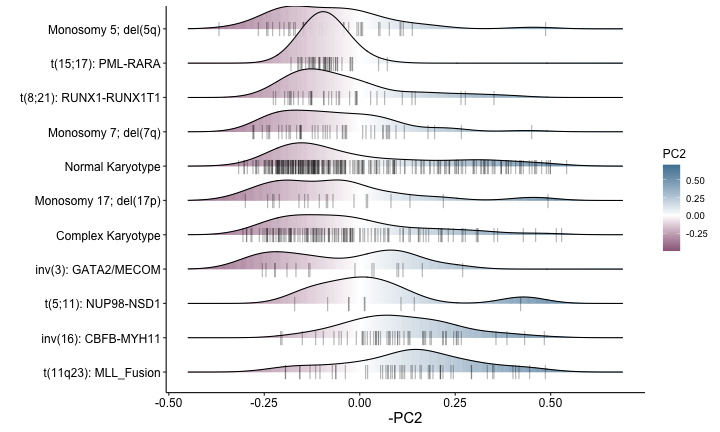

In [90]:
%%R -h 6 -w 10 --units in

alteration %>% 
    ggplot(aes(y = fct_reorder(Alteration, PC2), x = -PC2, fill=stat(x))) +
    geom_density_ridges_gradient(
        jittered_points = TRUE, scale = 1.5,
        position = position_points_jitter(width = 0.05, height = 0), 
        point_shape = '|', point_size = 5, point_alpha = 0.3) +
    scale_fill_gradient2(low='#71305D', high='#5083A2', name = "PC2") +
    theme_pubr() + 
    ylab('') + 
    xlim(c(-0.45, 0.69)) + 
    theme(legend.position='right', 
         axis.title.x = element_text(size=15)) #+ ggsave("Mutations/figures/Alteration_Hierarchy_PC1.png", dpi='retina', height=6, width=10)

# Prepare Mutation Combinations

Individual driver mutations tend to be heterogeneous - the consequences of each driver are dependent on co-mutated alterations

Get combinations of driver mutations and identify the combinations present in >= 5 patients. 

## Unbiased Combinations - All Mutations

In [42]:
combos = hcat.obs.copy()
combos['FLT3 (TKD)_mut'] = combos['FLT3_TKD']
combos['DNMT3A (R882)_mut'] = combos['DNMT3A_R882']
combos['DNMT3A (Other)_mut'] = np.where((combos['DNMT3A_mut'] == "Positive") & (combos['DNMT3A_R882'] != "Positive"), 'Positive', 'Negative')

### Mutation Pairs

In [205]:
from itertools import combinations
df = combos.iloc[:, combos.columns.str.contains('mut')]
df = df.replace(np.nan, 'NA').replace("Positive", "1").replace("Negative", "0").replace("NA", "0").astype('int')
df = df[df.sum(axis=0).sort_values(ascending=False).index] # Re order by frequency
df = df[df.sum(axis=1) >= 2]
df = df.loc[:,df.sum(axis=0) > 1]

cc = list(combinations(df.columns,2))
df = pd.concat([df[c[1]].multiply(df[c[0]]) for c in cc], axis=1, keys=cc)
df.columns = df.columns.map(' + '.join)
combo2 = df.loc[:,df.sum(axis=0) > 1].reset_index().rename(columns={'index':'Patient'})
del(df)
combo2

,Patient,NPM1_mut + FLT3-ITD_mut,NPM1_mut + DNMT3A_mut,NPM1_mut + NRAS_mut,NPM1_mut + DNMT3A (Other)_mut,NPM1_mut + FLT3_mut,NPM1_mut + IDH2_mut,NPM1_mut + TET2_mut,NPM1_mut + DNMT3A (R882)_mut,NPM1_mut + CEBPA_mut,...,PTPN11_mut + STAG2_mut,PTPN11_mut + EZH2_mut,KMT2A_mut + U2AF1_mut,KMT2A_mut + JAK2_mut,KMT2A_mut + BCOR_mut,SRSF2_mut + STAG2_mut,SRSF2_mut + BCOR_mut,WT1_mut + PHF6_mut,U2AF1_mut + PHF6_mut,EZH2_mut + CBL_mut
0,TCGA-AB-2805,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TCGA-AB-2807,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TCGA-AB-2810,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-AB-2811,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,TCGA-AB-2812,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,12H170,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
359,12H175,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
360,13H104,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
361,13H150,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [206]:
%%R -i combo2 

combo2 <- combo2 %>% gather(-Patient, key='Combo', value='Present') %>% 
    filter(Present > 0) %>% 
    mutate(dnmt3a_dup = if_else((Combo %>% str_detect("DNMT3A \\(")) & (Combo %>% str_detect("DNMT3A_mut")), 'TRUE', 'FALSE'), 
           flt3_dup = if_else((Combo %>% str_detect("FLT3 \\(")) & (Combo %>% str_detect("FLT3_mut")), 'TRUE', 'FALSE')) %>% 
    filter((dnmt3a_dup == 'FALSE') & (flt3_dup == 'FALSE')) %>%
    select(-dnmt3a_dup, -flt3_dup) %>% 
    mutate(Combo = Combo %>% str_replace_all('_mut', '')) 

combo2 %>% group_by(Combo) %>% 
    summarise(Total = sum(Present)) %>% 
    ungroup() %>% arrange(-Total) %>% head(20)

# A tibble: 20 x 2
   Combo                     Total
   <chr>                     <int>
 1 NPM1 + FLT3-ITD              64
 2 NPM1 + DNMT3A                63
 3 FLT3-ITD + DNMT3A            40
 4 NPM1 + DNMT3A (Other)        35
 5 NPM1 + DNMT3A (R882)         28
 6 NPM1 + FLT3                  28
 7 NPM1 + IDH2                  25
 8 FLT3-ITD + DNMT3A (Other)    23
 9 DNMT3A + FLT3                21
10 DNMT3A + IDH1                19
11 DNMT3A + IDH2                19
12 FLT3-ITD + DNMT3A (R882)     17
13 NPM1 + FLT3 (TKD)            17
14 DNMT3A (Other) + IDH2        16
15 NPM1 + TET2                  16
16 FLT3-ITD + IDH2              15
17 NPM1 + IDH1                  15
18 NPM1 + PTPN11                15
19 DNMT3A + NRAS                14
20 DNMT3A + FLT3 (TKD)          13


### Muation Triplets

In [207]:
from itertools import combinations
df = combos.iloc[:, combos.columns.str.contains('mut')]
df = df.replace(np.nan, 'NA').replace("Positive", "1").replace("Negative", "0").replace("NA", "0").astype('int')
df = df[df.sum(axis=0).sort_values(ascending=False).index] # Re order by frequency
df = df[df.sum(axis=1) >= 3]
df = df.loc[:,df.sum(axis=0) > 1]

cc = list(combinations(df.columns,3))
df = pd.concat([df[c[2]].multiply(df[c[1]]).multiply(df[c[0]]) for c in cc], axis=1, keys=cc)
df.columns = df.columns.map(' + '.join)
combo3 = df.loc[:,df.sum(axis=0) > 1].reset_index().rename(columns={'index':'Patient'})
del(df)
combo3

,Patient,NPM1_mut + FLT3-ITD_mut + DNMT3A_mut,NPM1_mut + FLT3-ITD_mut + DNMT3A (Other)_mut,NPM1_mut + FLT3-ITD_mut + FLT3_mut,NPM1_mut + FLT3-ITD_mut + IDH2_mut,NPM1_mut + FLT3-ITD_mut + TET2_mut,NPM1_mut + FLT3-ITD_mut + DNMT3A (R882)_mut,NPM1_mut + FLT3-ITD_mut + FLT3 (TKD)_mut,NPM1_mut + FLT3-ITD_mut + ASXL1_mut,NPM1_mut + FLT3-ITD_mut + PTPN11_mut,...,IDH2_mut + ASXL1_mut + SRSF2_mut,IDH2_mut + ASXL1_mut + SMC1A_mut,IDH2_mut + ASXL1_mut + STAG2_mut,IDH2_mut + ASXL1_mut + U2AF1_mut,TET2_mut + FLT3 (TKD)_mut + PTPN11_mut,TET2_mut + IDH1_mut + KMT2A_mut,TET2_mut + ASXL1_mut + EZH2_mut,IDH1_mut + KMT2A_mut + JAK2_mut,IDH1_mut + KMT2A_mut + BCOR_mut,ASXL1_mut + KIT_mut + SMC1A_mut
0,TCGA-AB-2807,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,TCGA-AB-2811,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TCGA-AB-2816,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-AB-2818,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TCGA-AB-2821,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,11H140,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218,12H106,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
219,12H170,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
220,13H104,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [208]:
%%R -i combo3 

combo3 <- combo3 %>% gather(-Patient, key='Combo', value='Present') %>% 
    filter(Present > 0) %>% 
    mutate(dnmt3a_dup = if_else((Combo %>% str_detect("DNMT3A \\(")) & (Combo %>% str_detect("DNMT3A_mut")), 'TRUE', 'FALSE'), 
           flt3_dup = if_else((Combo %>% str_detect("FLT3 \\(")) & (Combo %>% str_detect("FLT3_mut")), 'TRUE', 'FALSE')) %>% 
    filter((dnmt3a_dup == 'FALSE') & (flt3_dup == 'FALSE')) %>%
    select(-dnmt3a_dup, -flt3_dup) %>% 
    mutate(Combo = Combo %>% str_replace_all('_mut', ''))
    
combo3 %>% 
    group_by(Combo) %>% 
    summarise(Total = sum(Present)) %>% 
    ungroup() %>% arrange(-Total) %>% head(20)

# A tibble: 20 x 2
   Combo                             Total
   <chr>                             <int>
 1 NPM1 + FLT3-ITD + DNMT3A             30
 2 NPM1 + FLT3-ITD + DNMT3A (Other)     18
 3 NPM1 + DNMT3A + FLT3                 14
 4 NPM1 + FLT3-ITD + IDH2               13
 5 NPM1 + FLT3-ITD + DNMT3A (R882)      12
 6 NPM1 + FLT3 + DNMT3A (R882)          10
 7 NPM1 + DNMT3A + FLT3 (TKD)            8
 8 NPM1 + DNMT3A + PTPN11                8
 9 NPM1 + DNMT3A + IDH1                  7
10 NPM1 + DNMT3A + IDH2                  7
11 NPM1 + DNMT3A + NRAS                  7
12 FLT3-ITD + DNMT3A + IDH2              6
13 NPM1 + DNMT3A (Other) + IDH2          6
14 NPM1 + DNMT3A (R882) + PTPN11         6
15 NPM1 + DNMT3A + TET2                  6
16 FLT3-ITD + DNMT3A (Other) + IDH2      5
17 NPM1 + DNMT3A (R882) + FLT3 (TKD)     5
18 NPM1 + FLT3 + PTPN11                  5
19 NPM1 + FLT3-ITD + ASXL1               5
20 DNMT3A + FLT3 + IDH1                  4


### Mutation Quartets

In [209]:
from itertools import combinations
df = combos.iloc[:, combos.columns.str.contains('mut')]
df = df.replace(np.nan, 'NA').replace("Positive", "1").replace("Negative", "0").replace("NA", "0").astype('int')
df = df[df.sum(axis=0).sort_values(ascending=False).index] # Re order by frequency
df = df[df.sum(axis=1) >= 4]
df = df.loc[:,df.sum(axis=0) > 1]

cc = list(combinations(df.columns,4))
df = pd.concat([df[c[3]].multiply(df[c[2]]).multiply(df[c[1]]).multiply(df[c[0]]) for c in cc], axis=1, keys=cc)
df.columns = df.columns.map(' + '.join)
combo4 = df.loc[:,df.sum(axis=0) > 1].reset_index().rename(columns={'index':'Patient'})
del(df)
combo4

,Patient,NPM1_mut + FLT3-ITD_mut + DNMT3A_mut + DNMT3A (Other)_mut,NPM1_mut + FLT3-ITD_mut + DNMT3A_mut + FLT3_mut,NPM1_mut + FLT3-ITD_mut + DNMT3A_mut + IDH2_mut,NPM1_mut + FLT3-ITD_mut + DNMT3A_mut + DNMT3A (R882)_mut,NPM1_mut + FLT3-ITD_mut + DNMT3A_mut + ASXL1_mut,NPM1_mut + FLT3-ITD_mut + DNMT3A_mut + SMC1A_mut,NPM1_mut + FLT3-ITD_mut + DNMT3A_mut + SMC3_mut,NPM1_mut + FLT3-ITD_mut + DNMT3A_mut + RAD21_mut,NPM1_mut + FLT3-ITD_mut + DNMT3A (Other)_mut + IDH2_mut,...,DNMT3A_mut + FLT3_mut + FLT3 (TKD)_mut + SMC1A_mut,NRAS_mut + RUNX1_mut + TET2_mut + STAG2_mut,NRAS_mut + FLT3_mut + DNMT3A (R882)_mut + FLT3 (TKD)_mut,RUNX1_mut + FLT3_mut + PTPN11_mut + EZH2_mut,RUNX1_mut + IDH2_mut + ASXL1_mut + U2AF1_mut,RUNX1_mut + TET2_mut + ASXL1_mut + EZH2_mut,DNMT3A (Other)_mut + FLT3_mut + TET2_mut + FLT3 (TKD)_mut,DNMT3A (Other)_mut + FLT3_mut + FLT3 (TKD)_mut + IDH1_mut,DNMT3A (Other)_mut + FLT3_mut + FLT3 (TKD)_mut + WT1_mut,FLT3_mut + TET2_mut + FLT3 (TKD)_mut + PTPN11_mut
0,TCGA-AB-2811,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,TCGA-AB-2816,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,TCGA-AB-2818,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-AB-2821,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,TCGA-AB-2822,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,10H014,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134,10H078,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,11H140,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
136,12H170,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [210]:
%%R -i combo4 

combo4 <- combo4 %>% gather(-Patient, key='Combo', value='Present') %>% 
    filter(Present > 0) %>% 
    mutate(dnmt3a_dup = if_else((Combo %>% str_detect("DNMT3A \\(")) & (Combo %>% str_detect("DNMT3A_mut")), 'TRUE', 'FALSE'), 
           flt3_dup = if_else((Combo %>% str_detect("FLT3 \\(")) & (Combo %>% str_detect("FLT3_mut")), 'TRUE', 'FALSE')) %>% 
    filter((dnmt3a_dup == 'FALSE') & (flt3_dup == 'FALSE')) %>%
    select(-dnmt3a_dup, -flt3_dup) %>% 
    mutate(Combo = Combo %>% str_replace_all('_mut', ''))
    
combo4 %>% 
    group_by(Combo) %>% 
    summarise(Total = sum(Present)) %>% 
    ungroup() %>% arrange(-Total) %>% head(20)

# A tibble: 20 x 2
   Combo                                    Total
   <chr>                                    <int>
 1 NPM1 + FLT3-ITD + DNMT3A + IDH2              5
 2 NPM1 + FLT3-ITD + DNMT3A (Other) + IDH2      4
 3 NPM1 + DNMT3A + FLT3 + IDH1                  3
 4 NPM1 + DNMT3A + FLT3 + PTPN11                3
 5 NPM1 + FLT3 + DNMT3A (R882) + PTPN11         3
 6 NPM1 + FLT3-ITD + DNMT3A + ASXL1             3
 7 NPM1 + FLT3-ITD + DNMT3A + SMC3              3
 8 NPM1 + DNMT3A + FLT3 (TKD) + IDH1            2
 9 NPM1 + DNMT3A + FLT3 + TET2                  2
10 NPM1 + DNMT3A + IDH1 + PTPN11                2
11 NPM1 + DNMT3A + TET2 + PTPN11                2
12 NPM1 + FLT3 + DNMT3A (R882) + IDH1           2
13 NPM1 + FLT3 + TET2 + DNMT3A (R882)           2
14 NPM1 + FLT3-ITD + DNMT3A (Other) + ASXL1     2
15 NPM1 + FLT3-ITD + DNMT3A (Other) + RAD21     2
16 NPM1 + FLT3-ITD + DNMT3A (Other) + SMC1A     2
17 NPM1 + FLT3-ITD + DNMT3A (Other) + SMC3      2
18 NPM1 + FLT3-ITD + DNMT3A + F

In [211]:
pcs = hcat.obs[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'NMF1', 'NMF2', 'NMF3']].merge(hcat.to_df(), left_index=True, right_index=True).reset_index().rename(columns={'index':'Patient'})

In [212]:
%%R

combo4 %>% 
               group_by(Combo) %>% 
               summarise(Total = sum(Present)) %>% arrange(-Total)

# A tibble: 27 x 2
   Combo                                   Total
   <chr>                                   <int>
 1 NPM1 + FLT3-ITD + DNMT3A + IDH2             5
 2 NPM1 + FLT3-ITD + DNMT3A (Other) + IDH2     4
 3 NPM1 + DNMT3A + FLT3 + IDH1                 3
 4 NPM1 + DNMT3A + FLT3 + PTPN11               3
 5 NPM1 + FLT3 + DNMT3A (R882) + PTPN11        3
 6 NPM1 + FLT3-ITD + DNMT3A + ASXL1            3
 7 NPM1 + FLT3-ITD + DNMT3A + SMC3             3
 8 NPM1 + DNMT3A + FLT3 (TKD) + IDH1           2
 9 NPM1 + DNMT3A + FLT3 + TET2                 2
10 NPM1 + DNMT3A + IDH1 + PTPN11               2
# … with 17 more rows


In [213]:
%%R -i pcs

freqCombo <- combo2 %>% 
    group_by(Combo) %>% 
    summarise(Total = sum(Present)) %>% 
    filter(Total >= 5) %>% pull(Combo)
    
freqCombo <- c(freqCombo, 
               combo3 %>% 
               group_by(Combo) %>% 
               summarise(Total = sum(Present)) %>% 
               filter(Total >= 5) %>% pull(Combo))
    
freqCombo <- c(freqCombo, 
               combo4 %>% 
               group_by(Combo) %>% 
               summarise(Total = sum(Present)) %>% 
               filter(Total >= 5) %>% pull(Combo))

Combo_Hierarchy <- rbind(combo2 %>% mutate(ngenes = 2), 
      combo3 %>% mutate(ngenes = 3), 
      combo4 %>% mutate(ngenes = 4)) %>% 
    filter(Combo %in% freqCombo) %>% 
    left_join(pcs)
    
Combo_Hierarchy %>% write_csv("Mutations/Combination_Hierarchy.csv")
Combo_Hierarchy %>% head()

Joining, by = "Patient"
       Patient           Combo Present ngenes         PC1         PC2
1 TCGA-AB-2812 NPM1 + FLT3-ITD       1      2 -0.03912892  0.09196298
2 TCGA-AB-2836 NPM1 + FLT3-ITD       1      2 -0.16701576 -0.29365817
3 TCGA-AB-2853 NPM1 + FLT3-ITD       1      2 -0.23249686  0.13971217
4 TCGA-AB-2871 NPM1 + FLT3-ITD       1      2 -0.27734625  0.21988277
5 TCGA-AB-2877 NPM1 + FLT3-ITD       1      2 -0.04051054  0.06771321
6 TCGA-AB-2879 NPM1 + FLT3-ITD       1      2  0.10161100  0.14868930
          PC3         PC4         PC5      NMF1      NMF2      NMF3    GMP-like
1  0.06704459  0.13053872  0.22440073 0.7800127 0.6679658 0.3411702 0.168371394
2 -0.12953717 -0.01491662 -0.02237154 0.6585013 0.1535884 1.3871059 0.012912147
3  0.02865174  0.07668114  0.15827985 1.1064086 0.1469378 0.3505719 0.005779692
4 -0.03123003 -0.07464616 -0.01082885 1.3819101 0.1421714 0.3210246 0.016105900
5 -0.02615719  0.11748998  0.19971669 0.7856152 0.6690964 0.4351445 0.163719594
6 -0.0

# Plot Mutation Combinations

In [9]:
%%R
library(diptest)
library(ggridges)
Combo_Hierarchy <- read_csv("Data/Fig2_Cohort_Deconvolution/Combination_Hierarchy.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  Patient = col_character(),
  Combo = col_character(),
  Present = col_double(),
  ngenes = col_double(),
  PC1 = col_double(),
  PC2 = col_double(),
  PC3 = col_double(),
  PC4 = col_double(),
  PC5 = col_double(),
  NMF1 = col_double(),
  NMF2 = col_double(),
  NMF3 = col_double(),
  `GMP-like` = col_double(),
  `LSPC-Cycle` = col_double(),
  `LSPC-Primed` = col_double(),
  `LSPC-Quiescent` = col_double(),
  `Mono-like` = col_double(),
  `ProMono-like` = col_double(),
  `cDC-like` = col_double()
)



## Mutation Combinations - any VAF

Start by showing all mutation combinations that meet the threshold of >5 occurrences. 
Map them along PC1 and PC2. 

Note that this will involve a substantial amount of overlap between certain pairs, especially since some genes are subdivided by alteration (e.g. DNMT3A, FLT3)

R[write to console]: Picking joint bandwidth of 0.101



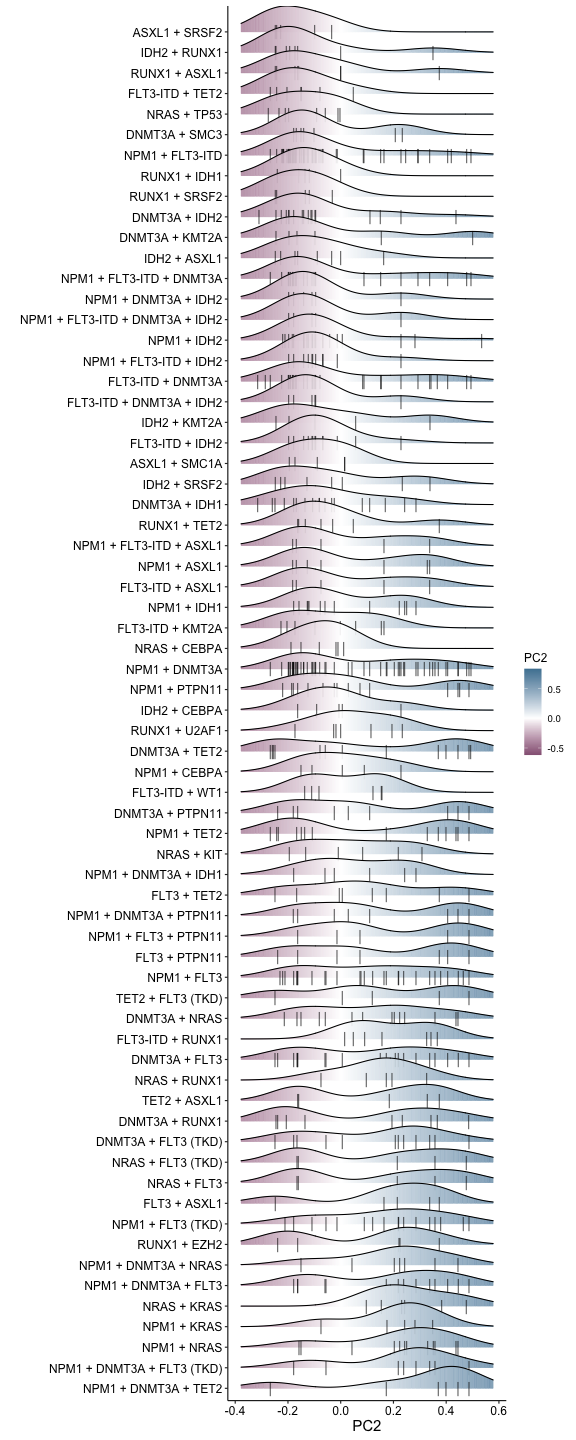

In [15]:
%%R -h 20 -w 8 --units in

Combo_Hierarchy_plot <- Combo_Hierarchy %>% 
    filter(!((Combo %>% str_detect('R882')) | (Combo %>% str_detect('Other'))))
    
Combo_Hierarchy_plot %>% 
    filter(ngenes >= 2) %>% 
    ggplot(aes(y = fct_reorder(Combo, -PC2), x = PC2, fill=stat(x))) +
    geom_density_ridges_gradient(
        jittered_points = TRUE, scale = 1.4,
        position = position_points_jitter(width = 0, height = 0), 
        point_shape = '|', point_size = 5, point_alpha = 0.6) +
    scale_fill_gradient2(low='#71305D', high='#5083A2', name = "PC2") +
    theme_pubr() + 
    ylab('') +
    xlim(c(-0.38, 0.58)) + 
    theme(legend.position='right', 
         axis.title.x = element_text(size=15))# + ggsave("Mutations/figures/Combo2_Hierarchy_PC2_AllCombos.png", dpi='retina', height=20, width=8)

R[write to console]: Picking joint bandwidth of 0.0672



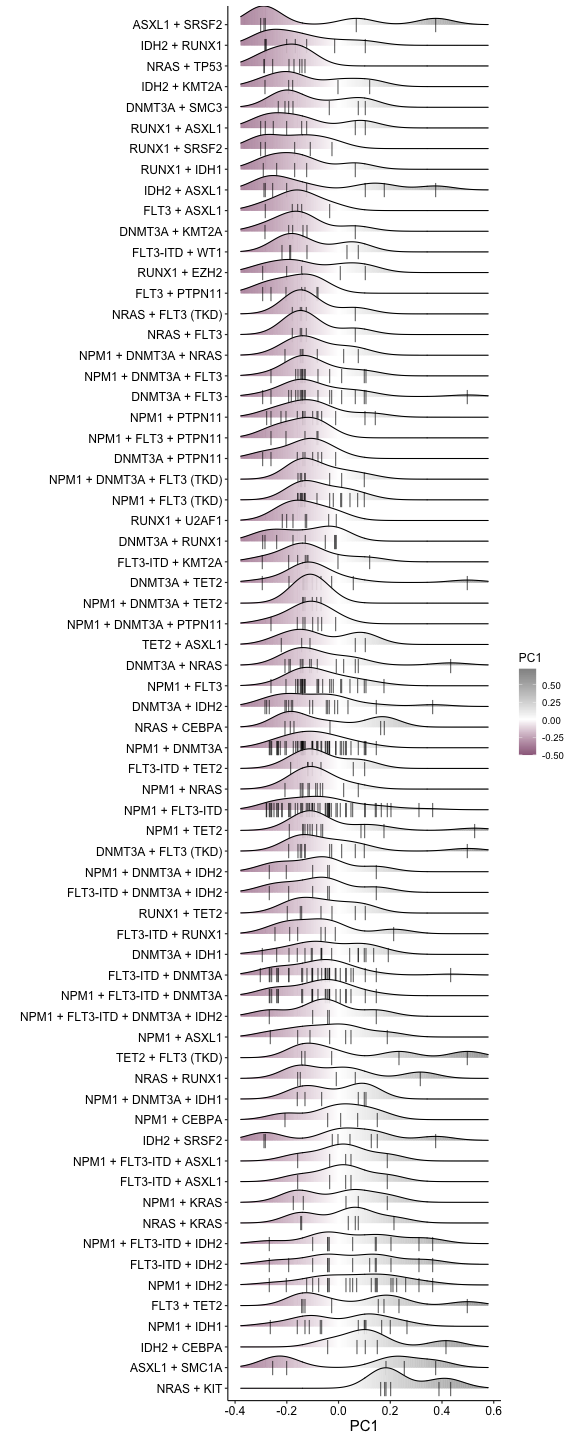

In [16]:
%%R -h 20 -w 8 --units in

Combo_Hierarchy_plot <- Combo_Hierarchy %>% 
    filter(!((Combo %>% str_detect('R882')) | (Combo %>% str_detect('Other'))))
    
Combo_Hierarchy_plot %>% 
    filter(ngenes >= 2) %>% 
    ggplot(aes(y = fct_reorder(Combo, -PC1), x = PC1, fill=stat(x))) +
    geom_density_ridges_gradient(
        jittered_points = TRUE, scale = 1.4,
        position = position_points_jitter(width = 0, height = 0), 
        point_shape = '|', point_size = 5, point_alpha = 0.6) +
    scale_fill_gradient2(low='#71305D', high='#949494', name = "PC1") +
    theme_pubr() + 
    ylab('') +
    xlim(c(-0.38, 0.58)) + 
    theme(legend.position='right', 
         axis.title.x = element_text(size=15)) #+ ggsave("Mutations/figures/Combo2_Hierarchy_PC1_AllCombos.png", dpi='retina', height=20, width=8)

Now plot focused mutation combinations.

    - Remove redundant DNMT3A and FLT3 alterations: 
        - If a specific alteration (e.g. DNMT3A R882, FLT3 TKD) has enough patients (>5), then use the specific alterations. 
        - If there are not enough patients for each specific alteration, use the overall gene (DNMT3A mut) irrespective of specific mutation
        
    - Prioritize well distributed alterations: 
        - Filter for genes whose distributions fall within the tightest bandwidth

R[write to console]: Picking joint bandwidth of 0.0628



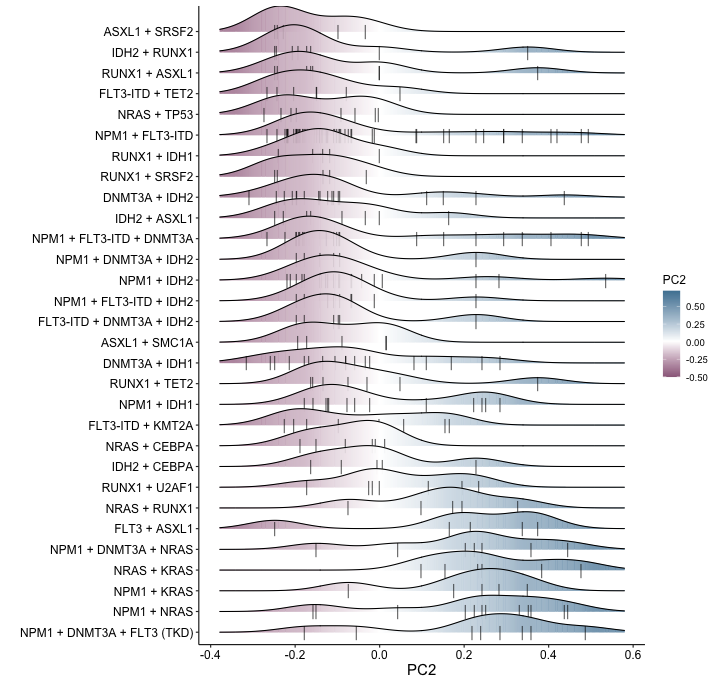

In [17]:
%%R -h 9.5 -w 10 --units in

Combo_Hierarchy_plot <- Combo_Hierarchy %>% 
    filter(!(Combo %in% c(# FLT3 removals
                          'FLT3 + DNMT3A (R882)', 'NPM1 + FLT3 + DNMT3A (R882)', 'DNMT3A + FLT3', 'NRAS + FLT3', 'NPM1 + FLT3', 'FLT3 + TET2', 
                          'NPM1 + DNMT3A + FLT3', 'FLT3 + DNMT3A (Other)', 
                          # Combo removals
                           'DNMT3A (R882) + FLT3 (TKD)', 'FLT3 + PTPN11', 'DNMT3A (R882) + PTPN11', 'DNMT3A + PTPN11', 
                          'FLT3-ITD + DNMT3A (Other)', 'FLT3-ITD + IDH2', 'NPM1 + FLT3-ITD + DNMT3A + IDH2',
                          # DNMT3A removals
                          'NPM1 + DNMT3A (R882) + PTPN11', 'DNMT3A (R882) + IDH1', 'DNMT3A (Other) + IDH1', 'NPM1 + DNMT3A (Other) + IDH2', 'DNMT3A + TET2',
                          'NPM1 + DNMT3A', 'NRAS + DNMT3A', 'DNMT3A (Other) + SMC3', 'FLT3-ITD + DNMT3A', 'DNMT3A (Other) + IDH2', 'FLT3-ITD + DNMT3A (Other) + IDH2',
                          'NPM1 + DNMT3A (R882) + FLT3 (TKD)', 'NPM1 + DNMT3A (Other)', 'NPM1 + FLT3-ITD + DNMT3A (Other)'
                      )))  

bw <- Combo_Hierarchy_plot %>%
    filter(Combo %in% unimodal) %>%
    group_by(Combo) %>% 
    summarise(bw = density(PC2)$bw) %>%
    top_n(29, -bw) %>% 
    pull(Combo)
    
Combo_Hierarchy_plot %>% 
    filter(ngenes >= 2) %>% 
    filter(Combo %in% c(bw, 'NPM1 + FLT3-ITD + DNMT3A')) %>% # DNMT3A + NPM1 + FLT3-ITD just misses the cutoff, so put it back in
    ggplot(aes(y = fct_reorder(Combo, -PC2), x = PC2, fill=stat(x))) +
    geom_density_ridges_gradient(
        jittered_points = TRUE, scale = 1.4,
        position = position_points_jitter(width = 0, height = 0), 
        point_shape = '|', point_size = 5, point_alpha = 0.6) +
    scale_fill_gradient2(low='#71305D', high='#5083A2', name = "PC2") +
    theme_pubr() + 
    ylab('') +
    xlim(c(-0.38, 0.58)) + 
    theme(legend.position='right', 
         axis.title.x = element_text(size=15))# + ggsave("Mutations/figures/Combo2_Hierarchy_PC2_unimodal.png", dpi='retina', height=9.5, width=10)

## Mutation Specific Analysis - DNMT3A

DNMT3A R882 correlates with more mature hierarchies than other DNMT3A mutations - let's evaluate that within the combinations it occurs in

In [19]:
%%R

DNMT3A <- Combo_Hierarchy %>% 
    mutate(Combo = ifelse((Combo == 'DNMT3A + RUNX1') & (Patient %in% c('13-00406', '13-00409', 'TCGA-AB-2916', 'TCGA-AB-2949')),
                 'DNMT3A (R882) + RUNX1', Combo)) %>% 
    filter((Combo %>% str_detect('R882')) | (Combo %>% str_detect('Other'))) %>% 
    filter(!(Combo %in% c('NPM1 + DNMT3A (R882) + FLT3 (TKD)', 'NPM1 + FLT3 + DNMT3A (R882)', 
                          'FLT3 + DNMT3A (Other)', 'FLT3 + DNMT3A (R882)', 'DNMT3A (Other) + IDH2', 
                          'DNMT3A (Other) + SMC3', 'DNMT3A (R882) + PTPN11', 'NPM1 + DNMT3A (R882) + PTPN11', 
                          'NPM1 + DNMT3A (Other) + IDH2', 'FLT3-ITD + DNMT3A (Other) + IDH2'))) %>% 
    pull(Combo) %>% unique() 

DNMT3A

 [1] "NPM1 + DNMT3A (Other)"            "NPM1 + DNMT3A (R882)"            
 [3] "FLT3-ITD + DNMT3A (Other)"        "FLT3-ITD + DNMT3A (R882)"        
 [5] "DNMT3A (R882) + RUNX1"            "NRAS + DNMT3A (Other)"           
 [7] "NRAS + DNMT3A (R882)"             "DNMT3A (Other) + RUNX1"          
 [9] "DNMT3A (Other) + TET2"            "DNMT3A (Other) + IDH1"           
[11] "DNMT3A (Other) + FLT3 (TKD)"      "DNMT3A (R882) + TET2"            
[13] "DNMT3A (R882) + IDH1"             "DNMT3A (R882) + FLT3 (TKD)"      
[15] "NPM1 + FLT3-ITD + DNMT3A (Other)" "NPM1 + FLT3-ITD + DNMT3A (R882)" 


R[write to console]: Picking joint bandwidth of 0.108



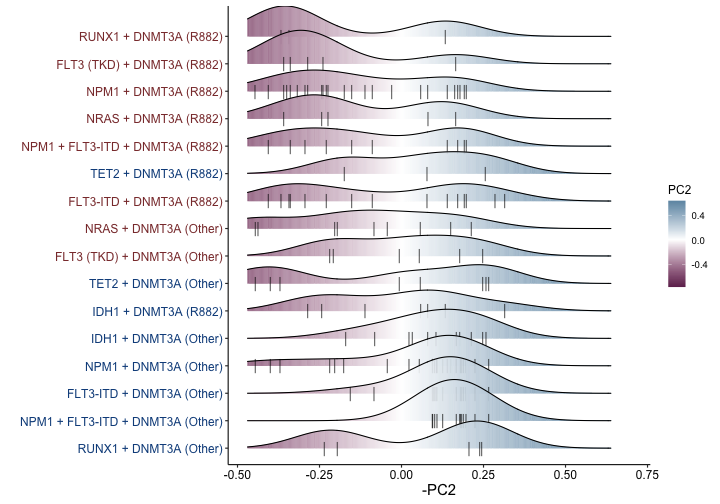

In [20]:
%%R -h 7 -w 10 --units in

Combo_Hierarchy %>% 
    mutate(Combo = ifelse((Combo == 'DNMT3A + RUNX1') & (Patient %in% c('13-00406', '13-00409', 'TCGA-AB-2916', 'TCGA-AB-2949')),
                 'DNMT3A (R882) + RUNX1', Combo)) %>% 
    filter(Combo %in% DNMT3A)%>% 
    mutate(Combo = ifelse(Combo == 'DNMT3A (Other) + IDH1', 'IDH1 + DNMT3A (Other)',
                         ifelse(Combo == 'DNMT3A (R882) + IDH1', 'IDH1 + DNMT3A (R882)',
                               ifelse(Combo == 'DNMT3A (Other) + RUNX1', 'RUNX1 + DNMT3A (Other)',
                                     ifelse(Combo == 'DNMT3A (R882) + RUNX1', 'RUNX1 + DNMT3A (R882)',
                                            ifelse(Combo == 'DNMT3A (Other) + TET2', 'TET2 + DNMT3A (Other)',
                                                   ifelse(Combo == 'DNMT3A (R882) + TET2', 'TET2 + DNMT3A (R882)',
                                                          ifelse(Combo == 'DNMT3A (Other) + FLT3 (TKD)', 'FLT3 (TKD) + DNMT3A (Other)',
                                                                 ifelse(Combo == 'DNMT3A (R882) + FLT3 (TKD)', 'FLT3 (TKD) + DNMT3A (R882)', Combo))))))))) %>%
    filter(Combo != 'DNMT3A (Other) + FLT3') %>% 
    ggplot(aes(y = fct_reorder(Combo, PC2), x = -PC2, fill=stat(x))) +
    geom_density_ridges_gradient(
        jittered_points = TRUE, scale = 1.5,
        position = position_points_jitter(width = 0, height = 0), 
        point_shape = '|', point_size = 5, point_alpha = 0.6) +
    scale_fill_gradient2(low='#71305D', high='#5083A2', name = "PC2") +
    theme_pubr() + 
    ylab('') +
    xlim(c(-0.47, 0.7)) + 
    theme(legend.position='right',
          axis.text.y = element_text(color=c('dodgerblue4', 'dodgerblue4', 'dodgerblue4', 'dodgerblue4', 'dodgerblue4', 'dodgerblue4', 'dodgerblue4', 
                                             'indianred4', 'indianred4', 'indianred4', 'dodgerblue4', 'indianred4', 'indianred4', 'indianred4', 'indianred4', 'indianred4')),
         axis.title.x = element_text(size=15)) #+ ggsave("Mutations/figures/DNMT3A_Hierarchy_PC2.png", dpi='retina', height=7, width=10)

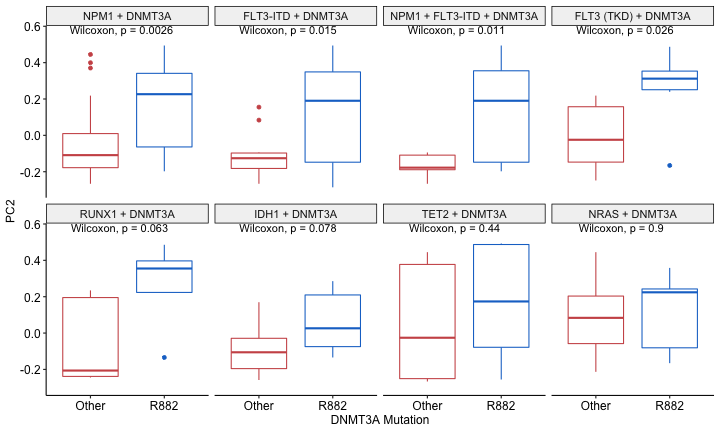

In [22]:
%%R -h 6 -w 10 --units in
library(ggpubr)
compare = list(c('Other', 'R882'))

DNMT3A_compare <- Combo_Hierarchy %>% 
    mutate(Combo = ifelse((Combo == 'DNMT3A + RUNX1') & (Patient %in% c('13-00406', '13-00409', 'TCGA-AB-2916', 'TCGA-AB-2949')),
                 'DNMT3A (R882) + RUNX1', Combo)) %>% 
    filter((Combo %>% str_detect('R882')) | (Combo %>% str_detect('Other'))) %>% 
    filter(!(Combo %in% c('NPM1 + DNMT3A (R882) + FLT3 (TKD)', 'NPM1 + FLT3 + DNMT3A (R882)', 
                          'FLT3 + DNMT3A (Other)', 'FLT3 + DNMT3A (R882)', 'DNMT3A (Other) + IDH2', 
                          'DNMT3A (Other) + SMC3', 'DNMT3A (R882) + PTPN11', 'NPM1 + DNMT3A (R882) + PTPN11', 
                          'NPM1 + DNMT3A (Other) + IDH2', 'FLT3-ITD + DNMT3A (Other) + IDH2'))) %>% 
    mutate(Combo = ifelse(Combo == 'DNMT3A (Other) + IDH1', 'IDH1 + DNMT3A (Other)',
                         ifelse(Combo == 'DNMT3A (R882) + IDH1', 'IDH1 + DNMT3A (R882)',
                               ifelse(Combo == 'DNMT3A (Other) + RUNX1', 'RUNX1 + DNMT3A (Other)',
                                     ifelse(Combo == 'DNMT3A (R882) + RUNX1', 'RUNX1 + DNMT3A (R882)',
                                            ifelse(Combo == 'DNMT3A (Other) + TET2', 'TET2 + DNMT3A (Other)',
                                                   ifelse(Combo == 'DNMT3A (R882) + TET2', 'TET2 + DNMT3A (R882)',
                                                          ifelse(Combo == 'DNMT3A (Other) + FLT3 (TKD)', 'FLT3 (TKD) + DNMT3A (Other)',
                                                                 ifelse(Combo == 'DNMT3A (R882) + FLT3 (TKD)', 'FLT3 (TKD) + DNMT3A (R882)',Combo))))))))) %>%
    filter(Combo != 'DNMT3A (Other) + FLT3') %>% 
    mutate(DNMT3A = ifelse(Combo %>% str_detect('R882'), 'R882',
                          ifelse(Combo %>% str_detect('Other'), 'Other', 'NA')),
           Partner = Combo %>% str_replace(' \\+ DNMT3A.*', '')) 
    
DNMT3A_compare %>% 
    mutate(Partner = paste0(Partner, ' + DNMT3A')) %>%
    mutate(Partner = factor(Partner, levels = c('NPM1 + DNMT3A', 'FLT3-ITD + DNMT3A', 'NPM1 + FLT3-ITD + DNMT3A', 'FLT3 (TKD) + DNMT3A', 
                                                'RUNX1 + DNMT3A', 'IDH1 + DNMT3A', 'TET2 + DNMT3A', 'NRAS + DNMT3A'))) %>%
    ggplot(aes(x = DNMT3A, y = PC2, color = DNMT3A)) + 
    geom_boxplot() + 
    facet_wrap(.~Partner, ncol=4) + 
    stat_compare_means() + 
    theme_pubr(legend='none') + 
    xlab('DNMT3A Mutation') +
    ylim(c(-0.3, 0.56)) +
    scale_color_manual(values=c('indianred3', 'dodgerblue3')) +
    theme(strip.text.x = element_text(size=11)) #+ 
    #ggsave("Mutations/figures/DNMT3A_compare_Hierarchy_PC2.png", dpi='retina', height=6, width=10)

## PC1

R[write to console]: Picking joint bandwidth of 0.0617

R[write to console]: Picking joint bandwidth of 0.0617



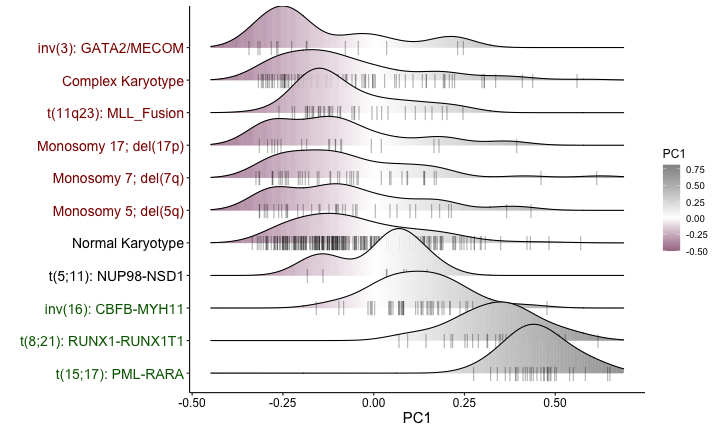

In [25]:
%%R -i combos -h 6 -w 10 --units in

alteration <- combos %>% 
    mutate(`Monosomy 5; del(5q)` = ifelse(`Monosomy 5` == "NA", `del(5q)`, `Monosomy 5`),
           `Monosomy 7; del(7q)` = ifelse(`Monosomy 7` == "NA", `del(7q)`, `Monosomy 7`),
           `Monosomy 17; del(17p)` = ifelse(`Monosomy 17` == "NA", `del(17p)`, `Monosomy 17`)) %>% 
    select(PC1, PC2, 'inv(3): GATA2/MECOM', 't(11q23): MLL_Fusion', 't(5;11): NUP98-NSD1', #'t(9;22): BCR-ABL',
           'inv(16): CBFB-MYH11', 't(8;21): RUNX1-RUNX1T1', 't(15;17): PML-RARA', 'Complex Karyotype', 'Normal Karyotype',
           #'Monosomy 5', 'del(5q)', 'Monosomy 7', 'del(7q)', 'Monosomy 17', 'del(17p)', 
           'Monosomy 5; del(5q)', 'Monosomy 7; del(7q)', 'Monosomy 17; del(17p)'
          ) %>%
    gather(-c(PC1, PC2), key='Alteration', value='Status') %>%
    mutate(Status = if_else((Status == "NA") | (Status == "Negative") | (Status == "Other"), 0, 1)) %>% 
    filter(Status > 0)

alteration %>% 
    ggplot(aes(y = fct_reorder(Alteration, -PC1), x = PC1, fill=stat(x))) +
    geom_density_ridges_gradient(
        jittered_points = TRUE, scale = 1.5,
        position = position_points_jitter(width = 0.05, height = 0), 
        point_shape = '|', point_size = 5, point_alpha = 0.3) +
    scale_fill_gradient2(low='#71305D', high='#949494', name = "PC1") +
    theme_pubr() + 
    ylab('') + 
    xlim(c(-0.45, 0.69)) + 
    theme(legend.position='right', 
          axis.text.y = element_text(color=c('dark green', 'dark green', 'dark green', 'black', 'black', 'dark red', 'dark red', 'dark red', 'dark red', 'dark red', 'dark red'), size=14),
          axis.title.x = element_text(size=15)) + ggsave("Mutations/figures/Alteration_Hierarchy_PC1_colored.png", dpi='retina', height=6, width=11)


`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


R[write to console]: Picking joint bandwidth of 0.0398



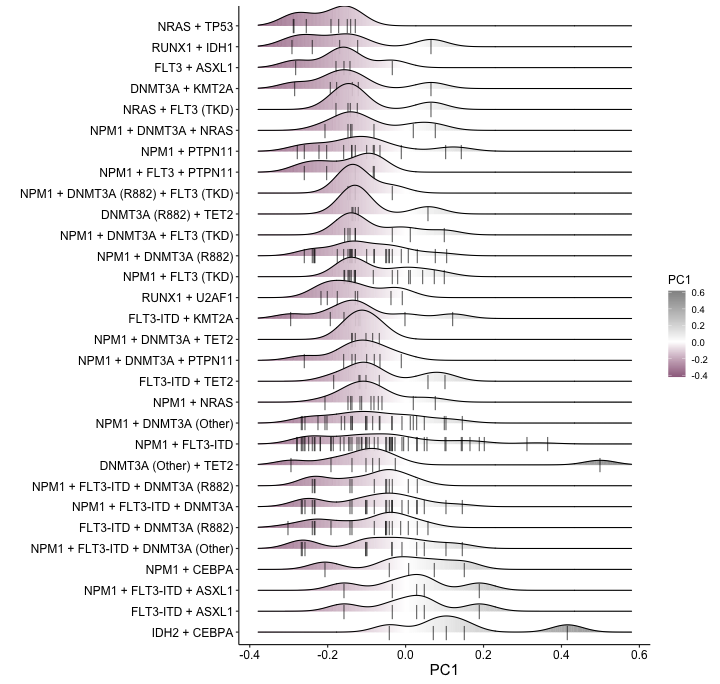

In [2133]:
%%R -h 9.5 -w 10 --units in

Combo_Hierarchy_plot <- Combo_Hierarchy %>% 
    filter(!(Combo %in% c(# FLT3 removals
                          'FLT3 + DNMT3A (R882)', 'NPM1 + FLT3 + DNMT3A (R882)', 'DNMT3A + FLT3', 'NRAS + FLT3', 'NPM1 + FLT3', 'FLT3 + TET2', 
                          'NPM1 + DNMT3A + FLT3', 'FLT3 + DNMT3A (Other)', 
                          # Combo removals
                           'DNMT3A (R882) + FLT3 (TKD)', 'FLT3 + PTPN11', 'DNMT3A (R882) + PTPN11', 'DNMT3A + PTPN11', 
                          'FLT3-ITD + DNMT3A (Other)', 'FLT3-ITD + IDH2', 'NPM1 + FLT3-ITD + DNMT3A + IDH2',
                          # DNMT3A removals
                          'NPM1 + DNMT3A (R882) + PTPN11', 'DNMT3A (R882) + IDH1', 'DNMT3A (Other) + IDH1', 'NPM1 + DNMT3A (Other) + IDH2', 'DNMT3A + TET2',
                          'NPM1 + DNMT3A', 'NRAS + DNMT3A', 'DNMT3A (Other) + SMC3', 'FLT3-ITD + DNMT3A', 'DNMT3A (Other) + IDH2', 'FLT3-ITD + DNMT3A (Other) + IDH2'
                      )))  

unimodal <- Combo_Hierarchy_plot %>% 
    group_by(Combo) %>% 
    summarise(multimodal = dip.test(PC1)$p.value) %>% 
    filter(multimodal > 0.1) %>% 
    pull(Combo)

bw <- Combo_Hierarchy_plot %>%
    filter(Combo %in% unimodal) %>%
    group_by(Combo) %>% 
    summarise(bw = density(PC1)$bw) %>%
    #top_n(30, -bw) %>% 
    top_n(30, -bw) %>% 
    #filter(bw < 0.0978612) %>% 
    pull(Combo)
    
Combo_Hierarchy_plot %>% 
    filter(ngenes >= 2) %>% 
    filter(#Combo %in% unimodal, 
           Combo %in% bw) %>% 
    ggplot(aes(y = fct_reorder(Combo, -PC1), x = PC1, fill=stat(x))) +
    geom_density_ridges_gradient(
        jittered_points = TRUE, scale = 1.4,
        position = position_points_jitter(width = 0, height = 0), 
        point_shape = '|', point_size = 5, point_alpha = 0.6) +
    scale_fill_gradient2(low='#71305D', high='#949494', name = "PC1") +
    theme_pubr() + 
    ylab('') +
    xlim(c(-0.38, 0.58)) + 
    theme(legend.position='right', 
         axis.title.x = element_text(size=15)) #+ ggsave("Mutations/figures/Combo2_Hierarchy_PC2_unimodal.png", dpi='retina', height=9.5, width=10)

## Mutation Combinations - VAF25

In [51]:
combos = hcat.obs.copy()
combos['DNMT3A_Other_VAF25'] = np.where((combos['DNMT3A_VAF25'] == "Positive") & (combos['DNMT3A_R882_VAF25'] != "Positive"), 'Positive', 'Negative')
combos = combos.rename(columns={'FLT3_TKD_VAF25':'FLT3 (TKD)_VAF25', 'DNMT3A_R882_VAF25':'DNMT3A (R882)_VAF25', 'DNMT3A_Other_VAF25':'DNMT3A (Other)_VAF25'})
combos = combos.drop('FLT3_VAF25', axis=1)

### Mutation Pairs

In [54]:
from itertools import combinations
df = combos.iloc[:, combos.columns.str.contains('VAF25')]
df = df.replace(np.nan, 'NA').replace("Positive", "1").replace("Negative", "0").replace("NA", "0").astype('int')
df = df[df.sum(axis=0).sort_values(ascending=False).index] # Re order by frequency
df = df[df.sum(axis=1) >= 2]
df = df.loc[:,df.sum(axis=0) > 1]

cc = list(combinations(df.columns,2))
df = pd.concat([df[c[1]].multiply(df[c[0]]) for c in cc], axis=1, keys=cc)
df.columns = df.columns.map(' + '.join)
combo2 = df.loc[:,df.sum(axis=0) > 1].reset_index().rename(columns={'index':'Patient'})
del(df)
combo2

,Patient,NPM1_VAF25 + FLT3-ITD_VAF25,NPM1_VAF25 + DNMT3A_VAF25,NPM1_VAF25 + TET2_VAF25,NPM1_VAF25 + DNMT3A (R882)_VAF25,NPM1_VAF25 + NRAS_VAF25,NPM1_VAF25 + DNMT3A (Other)_VAF25,NPM1_VAF25 + IDH2_VAF25,NPM1_VAF25 + IDH1_VAF25,NPM1_VAF25 + WT1_VAF25,...,ASXL1_VAF25 + JAK2_VAF25,ASXL1_VAF25 + STAG2_VAF25,KIT_VAF25 + ASXL2_VAF25,CEBPA_VAF25 + FLT3 (TKD)_VAF25,CEBPA_VAF25 + EZH2_VAF25,SRSF2_VAF25 + BCOR_VAF25,FLT3 (TKD)_VAF25 + SMC1A_VAF25,U2AF1_VAF25 + PHF6_VAF25,PTPN11_VAF25 + EZH2_VAF25,JAK2_VAF25 + CBL_VAF25
0,TCGA-AB-2805,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TCGA-AB-2807,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TCGA-AB-2810,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-AB-2811,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,TCGA-AB-2816,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,12H117,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
259,12H139,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260,13H056,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261,13H141,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
%%R -i combo2 

combo2 <- combo2 %>% gather(-Patient, key='Combo', value='Present') %>% 
    filter(Present > 0) %>% 
    mutate(dnmt3a_dup = if_else((Combo %>% str_detect("DNMT3A \\(")) & (Combo %>% str_detect("DNMT3A_VAF25")), 'TRUE', 'FALSE'), 
           flt3_dup = if_else((Combo %>% str_detect("FLT3 \\(")) & (Combo %>% str_detect("FLT3_VAF25")), 'TRUE', 'FALSE')) %>% 
    filter((dnmt3a_dup == 'FALSE') & (flt3_dup == 'FALSE')) %>%
    select(-dnmt3a_dup, -flt3_dup) %>% 
    mutate(Combo = Combo %>% str_replace_all('_VAF25', '')) 

combo2 %>% group_by(Combo) %>% 
    summarise(Total = sum(Present)) %>% 
    ungroup() %>% arrange(-Total) %>% head(20)

# A tibble: 20 x 2
   Combo                    Total
   <chr>                    <int>
 1 NPM1 + FLT3-ITD             49
 2 NPM1 + DNMT3A               42
 3 NPM1 + DNMT3A (R882)        26
 4 NPM1 + DNMT3A (Other)       16
 5 FLT3-ITD + DNMT3A           15
 6 NPM1 + IDH2                 15
 7 DNMT3A + IDH1               14
 8 NPM1 + IDH1                 13
 9 DNMT3A + IDH2               10
10 NPM1 + TET2                 10
11 DNMT3A + NRAS                9
12 FLT3-ITD + DNMT3A (R882)     9
13 NPM1 + FLT3 (TKD)            9
14 NPM1 + NRAS                  9
15 DNMT3A (Other) + IDH2        8
16 NPM1 + WT1                   8
17 TET2 + RUNX1                 8
18 DNMT3A (Other) + IDH1        7
19 DNMT3A (R882) + IDH1         7
20 DNMT3A + TET2                7


### Muation Triplets

In [58]:
from itertools import combinations
df = combos.iloc[:, combos.columns.str.contains('VAF25')]
df = df.replace(np.nan, 'NA').replace("Positive", "1").replace("Negative", "0").replace("NA", "0").astype('int')
df = df[df.sum(axis=0).sort_values(ascending=False).index] # Re order by frequency
df = df[df.sum(axis=1) >= 3]
df = df.loc[:,df.sum(axis=0) > 1]

cc = list(combinations(df.columns,3))
df = pd.concat([df[c[2]].multiply(df[c[1]]).multiply(df[c[0]]) for c in cc], axis=1, keys=cc)
df.columns = df.columns.map(' + '.join)
combo3 = df.loc[:,df.sum(axis=0) > 1].reset_index().rename(columns={'index':'Patient'})
del(df)
combo3

,Patient,NPM1_VAF25 + FLT3-ITD_VAF25 + DNMT3A_VAF25,NPM1_VAF25 + FLT3-ITD_VAF25 + TET2_VAF25,NPM1_VAF25 + FLT3-ITD_VAF25 + DNMT3A (R882)_VAF25,NPM1_VAF25 + FLT3-ITD_VAF25 + DNMT3A (Other)_VAF25,NPM1_VAF25 + FLT3-ITD_VAF25 + IDH2_VAF25,NPM1_VAF25 + FLT3-ITD_VAF25 + WT1_VAF25,NPM1_VAF25 + FLT3-ITD_VAF25 + ASXL1_VAF25,NPM1_VAF25 + DNMT3A_VAF25 + TET2_VAF25,NPM1_VAF25 + DNMT3A_VAF25 + DNMT3A (R882)_VAF25,...,TET2_VAF25 + RUNX1_VAF25 + SRSF2_VAF25,TET2_VAF25 + RUNX1_VAF25 + EZH2_VAF25,TET2_VAF25 + ASXL1_VAF25 + EZH2_VAF25,IDH2_VAF25 + RUNX1_VAF25 + ASXL1_VAF25,IDH2_VAF25 + ASXL1_VAF25 + SRSF2_VAF25,IDH2_VAF25 + ASXL1_VAF25 + STAG2_VAF25,RUNX1_VAF25 + IDH1_VAF25 + ASXL1_VAF25,RUNX1_VAF25 + ASXL1_VAF25 + SRSF2_VAF25,RUNX1_VAF25 + ASXL1_VAF25 + EZH2_VAF25,RUNX1_VAF25 + U2AF1_VAF25 + PHF6_VAF25
0,TCGA-AB-2811,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,TCGA-AB-2816,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,TCGA-AB-2818,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-AB-2821,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,TCGA-AB-2822,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,10H078,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,11H140,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
136,12H055,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,12H058,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
%%R -i combo3 

combo3 <- combo3 %>% gather(-Patient, key='Combo', value='Present') %>% 
    filter(Present > 0) %>% 
    mutate(dnmt3a_dup = if_else((Combo %>% str_detect("DNMT3A \\(")) & (Combo %>% str_detect("DNMT3A_VAF25")), 'TRUE', 'FALSE'), 
           flt3_dup = if_else((Combo %>% str_detect("FLT3 \\(")) & (Combo %>% str_detect("FLT3_VAF25")), 'TRUE', 'FALSE')) %>% 
    filter((dnmt3a_dup == 'FALSE') & (flt3_dup == 'FALSE')) %>%
    select(-dnmt3a_dup, -flt3_dup) %>% 
    mutate(Combo = Combo %>% str_replace_all('_VAF25', ''))
    
combo3 %>% 
    group_by(Combo) %>% 
    summarise(Total = sum(Present)) %>% 
    ungroup() %>% arrange(-Total) %>% head(20)

# A tibble: 20 x 2
   Combo                             Total
   <chr>                             <int>
 1 NPM1 + FLT3-ITD + DNMT3A              9
 2 NPM1 + DNMT3A + IDH1                  6
 3 NPM1 + FLT3-ITD + DNMT3A (R882)       5
 4 NPM1 + FLT3-ITD + IDH2                5
 5 NPM1 + DNMT3A (R882) + IDH1           4
 6 NPM1 + DNMT3A + FLT3 (TKD)            4
 7 NPM1 + DNMT3A + NRAS                  4
 8 NPM1 + DNMT3A + PTPN11                4
 9 NPM1 + FLT3-ITD + ASXL1               4
10 NPM1 + FLT3-ITD + DNMT3A (Other)      4
11 NPM1 + DNMT3A (R882) + FLT3 (TKD)     3
12 NPM1 + DNMT3A (R882) + PTPN11         3
13 NPM1 + DNMT3A + SMC3                  3
14 NPM1 + IDH2 + SRSF2                   3
15 NPM1 + NRAS + DNMT3A (Other)          3
16 TET2 + RUNX1 + ASXL1                  3
17 DNMT3A + FLT3 (TKD) + SMC1A           2
18 DNMT3A + IDH1 + PTPN11                2
19 DNMT3A + TET2 + IDH1                  2
20 DNMT3A + TET2 + SMC1A                 2


### Mutation Quartets

In [60]:
from itertools import combinations
df = combos.iloc[:, combos.columns.str.contains('VAF25')]
df = df.replace(np.nan, 'NA').replace("Positive", "1").replace("Negative", "0").replace("NA", "0").astype('int')
df = df[df.sum(axis=0).sort_values(ascending=False).index] # Re order by frequency
df = df[df.sum(axis=1) >= 4]
df = df.loc[:,df.sum(axis=0) > 1]

cc = list(combinations(df.columns,4))
df = pd.concat([df[c[3]].multiply(df[c[2]]).multiply(df[c[1]]).multiply(df[c[0]]) for c in cc], axis=1, keys=cc)
df.columns = df.columns.map(' + '.join)
combo4 = df.loc[:,df.sum(axis=0) > 1].reset_index().rename(columns={'index':'Patient'})
del(df)
combo4

,Patient,NPM1_VAF25 + FLT3-ITD_VAF25 + DNMT3A_VAF25 + DNMT3A (R882)_VAF25,NPM1_VAF25 + FLT3-ITD_VAF25 + DNMT3A_VAF25 + DNMT3A (Other)_VAF25,NPM1_VAF25 + FLT3-ITD_VAF25 + DNMT3A_VAF25 + ASXL1_VAF25,NPM1_VAF25 + FLT3-ITD_VAF25 + DNMT3A (Other)_VAF25 + ASXL1_VAF25,NPM1_VAF25 + DNMT3A_VAF25 + DNMT3A (R882)_VAF25 + IDH1_VAF25,NPM1_VAF25 + DNMT3A_VAF25 + DNMT3A (R882)_VAF25 + FLT3 (TKD)_VAF25,NPM1_VAF25 + DNMT3A_VAF25 + DNMT3A (R882)_VAF25 + PTPN11_VAF25,NPM1_VAF25 + DNMT3A_VAF25 + NRAS_VAF25 + DNMT3A (Other)_VAF25,NPM1_VAF25 + DNMT3A_VAF25 + DNMT3A (Other)_VAF25 + IDH1_VAF25,NPM1_VAF25 + DNMT3A_VAF25 + DNMT3A (Other)_VAF25 + ASXL1_VAF25,NPM1_VAF25 + DNMT3A_VAF25 + DNMT3A (Other)_VAF25 + SMC3_VAF25,NPM1_VAF25 + DNMT3A_VAF25 + IDH1_VAF25 + PTPN11_VAF25,FLT3-ITD_VAF25 + DNMT3A_VAF25 + DNMT3A (R882)_VAF25 + RUNX1_VAF25,FLT3-ITD_VAF25 + DNMT3A_VAF25 + DNMT3A (Other)_VAF25 + IDH2_VAF25,FLT3-ITD_VAF25 + DNMT3A_VAF25 + DNMT3A (Other)_VAF25 + ASXL1_VAF25,DNMT3A_VAF25 + TET2_VAF25 + DNMT3A (Other)_VAF25 + IDH1_VAF25,DNMT3A_VAF25 + TET2_VAF25 + DNMT3A (Other)_VAF25 + SMC1A_VAF25,TET2_VAF25 + RUNX1_VAF25 + ASXL1_VAF25 + EZH2_VAF25
0,TCGA-AB-2811,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,TCGA-AB-2816,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,TCGA-AB-2818,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,TCGA-AB-2821,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,TCGA-AB-2822,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,03H083,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
64,05H042,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
65,04H123,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66,10H078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
%%R -i combo4 

combo4 <- combo4 %>% gather(-Patient, key='Combo', value='Present') %>% 
    filter(Present > 0) %>% 
    mutate(dnmt3a_dup = if_else((Combo %>% str_detect("DNMT3A \\(")) & (Combo %>% str_detect("DNMT3A_VAF25")), 'TRUE', 'FALSE'), 
           flt3_dup = if_else((Combo %>% str_detect("FLT3 \\(")) & (Combo %>% str_detect("FLT3_VAF25")), 'TRUE', 'FALSE')) %>% 
    filter((dnmt3a_dup == 'FALSE') & (flt3_dup == 'FALSE')) %>%
    select(-dnmt3a_dup, -flt3_dup) %>% 
    mutate(Combo = Combo %>% str_replace_all('_VAF25', ''))
    
combo4 %>% 
    group_by(Combo) %>% 
    summarise(Total = sum(Present)) %>% 
    ungroup() %>% arrange(-Total) %>% head(20)

# A tibble: 4 x 2
  Combo                                    Total
  <chr>                                    <int>
1 NPM1 + DNMT3A + IDH1 + PTPN11                2
2 NPM1 + FLT3-ITD + DNMT3A (Other) + ASXL1     2
3 NPM1 + FLT3-ITD + DNMT3A + ASXL1             2
4 TET2 + RUNX1 + ASXL1 + EZH2                  2


In [62]:
pcs = hcat.obs[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'NMF1', 'NMF2', 'NMF3']].merge(hcat.to_df(), left_index=True, right_index=True).reset_index().rename(columns={'index':'Patient'})

In [64]:
%%R -i pcs

freqCombo <- combo2 %>% 
    group_by(Combo) %>% 
    summarise(Total = sum(Present)) %>% 
    filter(Total >= 4) %>% pull(Combo)
    
freqCombo <- c(freqCombo, 
               combo3 %>% 
               group_by(Combo) %>% 
               summarise(Total = sum(Present)) %>% 
               filter(Total >= 4) %>% pull(Combo))
    
freqCombo <- c(freqCombo, 
               combo4 %>% 
               group_by(Combo) %>% 
               summarise(Total = sum(Present)) %>% 
               filter(Total >= 4) %>% pull(Combo))

Combo_Hierarchy <- rbind(combo2 %>% mutate(ngenes = 2), 
      combo3 %>% mutate(ngenes = 3), 
      combo4 %>% mutate(ngenes = 4)) %>% 
    filter(Combo %in% freqCombo) %>% 
    left_join(pcs)
    
Combo_Hierarchy %>% write_csv("Data/Fig2_Cohort_Deconvolution/Combination_Hierarchy_VAF25.csv")
Combo_Hierarchy %>% head()

Joining, by = "Patient"
   Patient           Combo Present ngenes         PC1         PC2           PC3
1 12-00051 NPM1 + FLT3-ITD       1      2 -0.26056141  0.21748760  0.0079597961
2 13-00165 NPM1 + FLT3-ITD       1      2 -0.21860877  0.20346950 -0.1043055728
3 13-00365 NPM1 + FLT3-ITD       1      2 -0.09250189  0.15539467 -0.1490716189
4 13-00513 NPM1 + FLT3-ITD       1      2 -0.02727351 -0.08656269 -0.0253706686
5 14-00001 NPM1 + FLT3-ITD       1      2  0.05502974  0.14036320 -0.0006235733
6 14-00259 NPM1 + FLT3-ITD       1      2 -0.07952219 -0.40585366 -0.0065567163
          PC4         PC5      NMF1      NMF2      NMF3   GMP-like LSPC-Cycle
1 -0.14743613  0.14980498 1.3054705 0.1394483 0.2675261 0.02390466 0.10418780
2 -0.09907082 -0.01731242 1.3195909 0.3210883 0.3689132 0.06916744 0.08539065
3 -0.04620885  0.05941009 1.0708672 0.6341533 0.3894898 0.15071665 0.00000000
4  0.33410025  0.01478255 0.6117972 0.6614584 0.7784523 0.15160762 0.25671479
5  0.02545252  0.09617571 

R[write to console]: Picking joint bandwidth of 0.0863



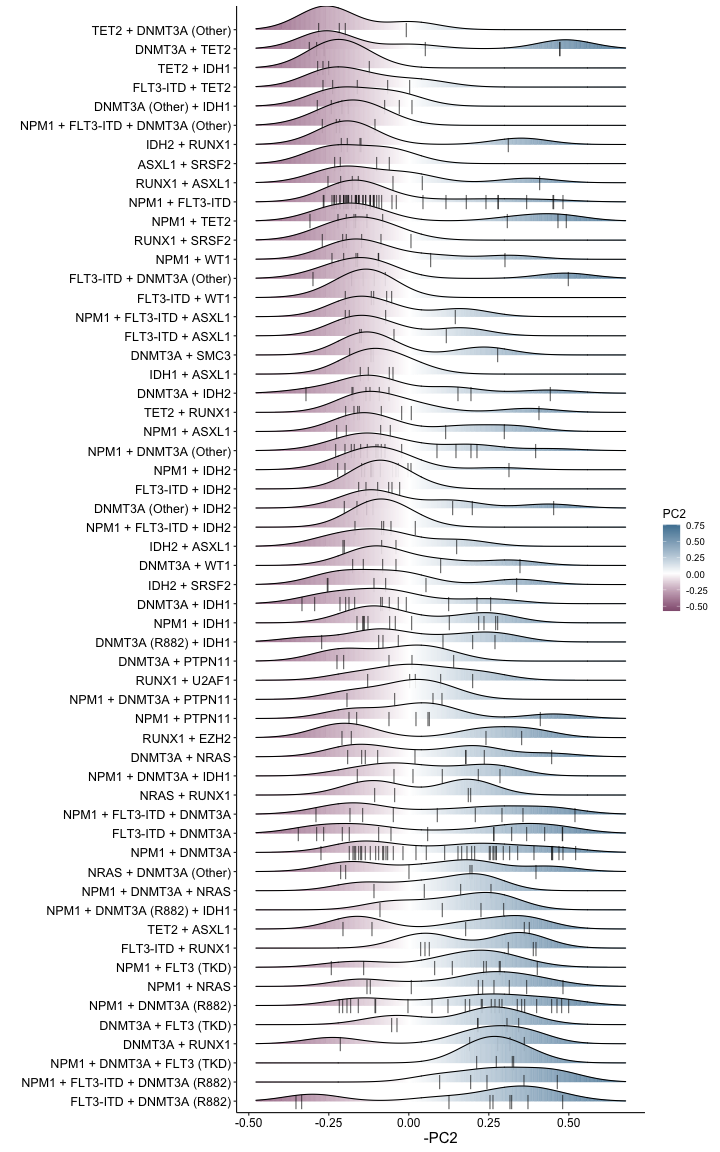

In [70]:
%%R -h 16 -w 10 --units in
library(diptest)

unimodal <- Combo_Hierarchy %>% 
    group_by(Combo) %>% 
    summarise(multimodal = dip.test(PC2)$p.value) %>% 
    filter(multimodal > 0.3) %>% 
    pull(Combo)

Combo_Hierarchy %>% 
    filter(ngenes >= 2) %>% 
    ggplot(aes(y = fct_reorder(Combo, PC2), x = -PC2, fill=stat(x))) +
    geom_density_ridges_gradient(
        jittered_points = TRUE, scale = 1.5,
        position = position_points_jitter(width = 0.05, height = 0), 
        point_shape = '|', point_size = 5, point_alpha = 0.6) +
    scale_fill_gradient2(low='#71305D', high='#5083A2', name = "PC2") +
    theme_pubr() + 
    ylab('') + 
    xlim(c(-0.48, 0.68)) + 
    theme(legend.position='right', 
         axis.title.x = element_text(size=15),
         axis.text.y = element_text(size=12.5)) #+ ggsave("Mutations/figures/NPM1_combos_Hierarchy_PC2_very_unimodal.png", dpi='retina', height=7, width=10)